In [335]:
import math
import typing as ty
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [336]:
import lib

In [337]:
from sklearn.model_selection import train_test_split

data = np.load('../data/tabular_data/6_cardio.npz', allow_pickle=True)
X, y = data['X'], data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y,\
    test_size=0.3, shuffle=True, random_state=1, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1281, 21), (550, 21), (1281,), (550,))

In [338]:
n_train = X_train.shape[0]  # 1281
train_features = torch.tensor(X_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.float32)
loss = (
    F.binary_cross_entropy_with_logits
)
in_features = X_train.shape[1]  # 21
out_features = 1
k, num_epochs, lr, weight_decay, batch_size = 5, 30, 0.01, 0.001, 1281

In [339]:
class MLP(nn.Module):
    def __init__(
        self,
        d_in: int,
        d_layers: ty.List[int],
        dropout: float,
        d_out: int,
    ) -> None:
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.Linear(d_layers[i - 1] if i else d_in, x)
                for i, x in enumerate(d_layers)
            ]
        )
        self.dropout = dropout
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)

    # forward function for mlp
    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
            if self.dropout:
                x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.head(x)
        # squeeze if it is the case of: [100, 1] -> [100]
        return x.squeeze(-1)


In [340]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = lib.load_array((train_features, train_labels), batch_size)
    # use Adam optimizer
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        epoch_losses = []
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            epoch_losses.append(l.detach())
        epoch_losses = torch.stack(epoch_losses).tolist()  # no dim change
        train_ls.append(sum(epoch_losses) / len(epoch_losses))  # mean of all mini-batch losses
        if test_labels is not None:
            epoch_test_losses = loss(net(test_features), test_labels).detach()
            test_ls.append(epoch_test_losses)
    return train_ls, test_ls

In [341]:
# k-fold cross validation from scratch
# can also refer to scikit-learn API
# actually, k fold validation here is not necessary (not used)
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)

        net = MLP(in_features, [32, 32, 32, 32], 0.1, out_features)

        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]  # last epoch result, i.e. the best
        valid_l_sum += valid_ls[-1]
        # use the first fold for plotting
        if i == 0:
            lib.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='BCE', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'Fold {i + 1}，train bce: {float(train_ls[-1]):f}, '
              f'val bce: {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

Fold 1，train bce: 0.093606, val bce: 0.125358
Fold 2，train bce: 0.050899, val bce: 0.083408
Fold 3，train bce: 0.079149, val bce: 0.092096
Fold 4，train bce: 0.083103, val bce: 0.166481
Fold 5，train bce: 0.085155, val bce: 0.123307
5-fold validation: avg train bce: 0.078382, avg val bce: 0.118130


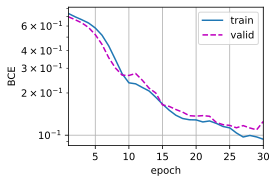

In [342]:

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train bce: {float(train_l):f}, '
      f'avg val bce: {float(valid_l):f}')

In [343]:
import sklearn.metrics as skm
import scipy
# you can skip k fold and directly train and test here
def train_and_pred(train_features, test_features, train_labels, test_labels,
                   num_epochs, lr, weight_decay, batch_size):

    net = MLP(in_features, [32, 32, 32, 32], 0.01, out_features)

    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    lib.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='bce', xlim=[1, num_epochs], yscale='log')
    print(f'train bce: {float(train_ls[-1]):f}')
    # apply the network to the test set
    logits = net(test_features).detach().numpy()
    probs = scipy.special.expit(logits)
    labels = np.round(probs).astype('int64')
    # calculate accuracy
    print(probs)
    print(test_labels)
    result = skm.roc_auc_score(test_labels, labels)
    print(f'test auc: {result:.4f}')

train bce: 0.056167
[4.98910109e-03 8.19082935e-09 1.15392097e-11 6.74055159e-01
 2.24241242e-02 2.98545207e-03 1.49338366e-02 7.63689935e-01
 8.37899350e-09 4.73674859e-08 1.31879035e-10 1.06262546e-20
 4.79115212e-18 6.57102020e-12 8.87811424e-09 1.70517800e-04
 4.82220261e-15 2.68737407e-04 1.55492942e-13 8.39402318e-01
 6.58167504e-14 7.00871450e-09 1.09324306e-13 1.75374780e-17
 1.57950198e-11 2.73203837e-09 6.14514377e-08 5.67693592e-12
 7.08377627e-12 1.11881981e-07 2.04398227e-03 1.10286131e-30
 7.83618759e-07 3.20554664e-15 2.58817821e-08 3.78251874e-09
 1.61741572e-18 2.77863886e-15 3.15991877e-09 1.22907907e-01
 8.41553867e-01 4.94322916e-11 7.29646325e-01 5.34044944e-12
 4.18335432e-04 1.43130074e-11 1.28261526e-08 1.12624271e-07
 6.19733604e-15 7.79189074e-11 2.61767542e-25 8.76285753e-07
 2.51657188e-01 1.37561835e-06 1.23300473e-04 3.90829342e-07
 5.48092885e-07 1.62383856e-11 4.55217377e-17 1.11272563e-13
 1.05198512e-06 4.52315928e-11 2.42246685e-08 1.37245181e-04
 2.1

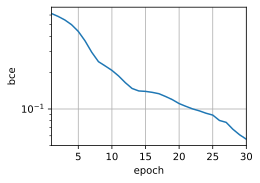

Bad pipe message: %s [b's\x04`\xa7E,\x10\x96\xbax\xf5\xe0\x8a\xddh\x80\x8a\xb6 dX\xef\x9bM_\xc8\xed\xe5\xbbK,\xe69#&n\x91\xfe\r\xab`\xd7\xbb\x01\x83\xee\xee\\\xe8N\xf8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00', b'\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \x9d\x8ei\x8f\x08\xee\xd8Y\xbb\xed\x8d(\xd2r\x90\x98`+\x1c\xf4\xf4\xe8GG]\xa7jf\x7f\x1d2']
Bad pipe message: %s [b'\xc3\xc8\xab\x99\xa7\xf1q\xab\x87g\x80\xa1bO\xc4\xbd\xd3\x93 \xa8\xe5\x93\xa3\xb5\x1bw\x7f\x83\xcf\x92W\xb9\xbc\xb9Cf\xc0WU\x8e\xe6Ri\xb5$E%\xa1\x88\xab]\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x

In [344]:
train_and_pred(train_features, test_features, train_labels, y_test,
                num_epochs, lr, weight_decay, batch_size)